# Signal Classification

訊號與圖的分類一樣，在preprocess後可使用神經網路做一些AI任務，例如訊號分類、迴歸還有生成等等。

這個部分我們用音訊作為訊號的範例，來試著將聲音訊號做分類，包含以下部分:
- Audio Data Loader
- RNN audio classification
- CNN audio classification

開始之前我們先準備一些內容。

我們使用的範例資料集是tensorflow提供的[Mini Speech Commands](https://ai.googleblog.com/2017/08/launching-speech-commands-dataset.html)資料集，從官網下載。

In [1]:
!wget http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip
!unzip mini_speech_commands.zip

Streaming output truncated to the last 5000 lines.
  inflating: mini_speech_commands/up/1ecfb537_nohash_1.wav  
  inflating: __MACOSX/mini_speech_commands/up/._1ecfb537_nohash_1.wav  
  inflating: mini_speech_commands/up/c137814b_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._c137814b_nohash_0.wav  
  inflating: mini_speech_commands/up/135c6841_nohash_2.wav  
  inflating: __MACOSX/mini_speech_commands/up/._135c6841_nohash_2.wav  
  inflating: mini_speech_commands/up/3eb8764c_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._3eb8764c_nohash_0.wav  
  inflating: mini_speech_commands/up/caf9fceb_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._caf9fceb_nohash_0.wav  
  inflating: mini_speech_commands/up/f34e6f44_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._f34e6f44_nohash_0.wav  
  inflating: mini_speech_commands/up/61a0d340_nohash_0.wav  
  inflating: __MACOSX/mini_speech_commands/up/._61a0d340_nohash_0.wav  
  inflating: mini_

In [2]:
import librosa
import IPython.display as idp # 播音工具
import librosa.display as ldp # 畫頻譜圖工具
import numpy as np # 輔助運算
import matplotlib.pyplot as plt # 輔助畫圖

# import model用到的內容
import tensorflow as tf

## Audio Data Loader

與前面CNN相同，需要有data loader去對資料做讀取，而tensorflow沒有原生讀音訊的data loader (TF 2.11有，但在Colab上要另外灌TF2.11)，所以這部分要自己寫。

### 讀取音訊檔及資料切分

In [3]:
from glob import glob #拿來列資料夾內容的小套件
from sklearn.model_selection import train_test_split # 切分資料集用

def find_class(x):
    # 根據格式，找到所屬class
    return x.strip('/')[-2]

def audio_folder_datasets( dataset_path,class_dictionary, sr=22050, duration=-1):
    # 輸入: 
    ## dataset_path - 資料夾，內有數個不同class的資料夾，內有.wav檔
    ## class_dictionary - dictionary物件，對應每個資料夾的class
    ## sr -  讀取的sampling rate
    ## duration - 可指定秒數(float32)，不指定則為原檔長度
    file_names = []
    labels = []
    for cls, class_id in class_dictionary.items():
        f_list=glob(dataset_path+f'{cls}/*.wav') # 找到該class的所有檔案
        file_names.extend(f_list) # 加入列表
        labels.extend([class_id]*len(f_list)) # 加入相應labels
    print("total:",f"{len(file_names)} files of {len(class_dictionary)} classes")
    
    @tf.function
    def load_wav(fname):
        # 使用指定sampling rate, duration讀檔
        # 這邊要用到librosa的loading才有re-sample，若已經知道每個檔案sampling rate也可以用tensorflow的tf.audio
        # 可參考: https://www.kaggle.com/code/lkergalipatak/bird-audio-classification-with-tensorflow

        x= tf.numpy_function(
            lambda x: librosa.util.fix_length(
                librosa.load(x, sr=sr, duration=duration)[0],
                size=int(sr*duration),
                mode='edge'),
            inp=[fname], Tout=tf.float32)
        return x

    def get_dataset(paths_,labels_):
        # 得到所有資料夾名稱
        path_ds = tf.data.Dataset.from_tensor_slices(paths_) # 轉換成檔名的Dataset物件
        label_ds= tf.data.Dataset.from_tensor_slices(labels_)

        data_ds = path_ds.map(
                load_wav,
                num_parallel_calls=tf.data.AUTOTUNE,
            )
        return tf.data.Dataset.zip((data_ds,label_ds))

    fname_train, fname_val, label_train, label_val = train_test_split(file_names,labels,test_size=0.2)
    return get_dataset(fname_train,label_train), get_dataset(fname_val,label_val)
    

生成一個dataset拿來用作基礎。

In [4]:
# 準備一些參數輸入進function生成dataset
DATASET_PATH='mini_speech_commands/'
class_dict = {
    'down':0,
    'go':1,
    'left':2,
    'no':3,
    'right':4,
    'stop':5,
    'up':6,
    'yes':7
}
SR = 20500
DURATION = 0.8
tran_ds, val_ds = audio_folder_datasets(DATASET_PATH, class_dict, sr=SR, duration=DURATION)

total: 8000 files of 8 classes


dataset一次丟出一個signal以及一個label

觀察data基本性質


 (16400,) -0.14309989 0.3726315
tf.Tensor(2, shape=(), dtype=int32)


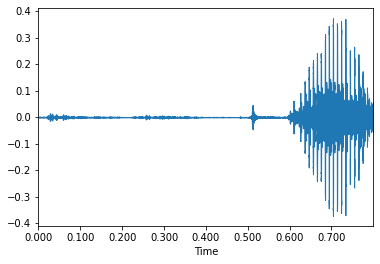

In [5]:
for x,y in tran_ds:
    print('\n',x.shape,x.numpy().min(),x.numpy().max())
    print(y)
    break
# 畫出來
ldp.waveplot(x.numpy().squeeze(), sr=SR)

# 聽看看
idp.Audio(x.numpy().squeeze(), rate=SR)

畫出一個例子

### 輸入NN前做轉換

在預處裡時使用librosa會很慢，幸好與```librosa.stft```類似，可以使用```tensorflow.signal.stft```做時頻分析，在操作的各種過程中只能用tf function來操作。

其axis為[time,frequency]，與librosa相反，使用```librosa.specshow```觀察時記得要做transpose。

為什麼要反過來是為了配合RNN的預設axis [batch,time,...]，將time擺在batch後面第一位。

若希望使用CNN模型，記得在最後多加一個空的axis，因為CNN適用的axis是[batch, hight, width, channels]。

In [6]:
N=512
H=128
def get_stft(waveform):
    # 做STFT (用tensorflow得比較快)
    spectrogram = tf.signal.stft(
        waveform, frame_length=N, frame_step=H)
    # 這邊frame_length是librosa的n_fft
    #     frame_step是librosa的hop_length
    # 使用tf.signal stft出來時，單位為((timepoints-n_fft)/hop_length, n_fft/2)
    # 這是為了配合RNN等模型的

    # 取magnitude
    spectrogram = tf.abs(spectrogram)

    # 若是多加一個維度，可以用於CNN，shape (`batch_size`, `height`, `width`, `channels`).
    # spectrogram = spectrogram[..., tf.newaxis]
    return spectrogram

# 使用STFT當作preprocess function
tran_ds_stft= tran_ds.map(lambda x,y: (get_stft(x), y), num_parallel_calls=tf.data.AUTOTUNE).cache().shuffle(6400).prefetch(tf.data.AUTOTUNE)
val_ds_stft= val_ds.map(lambda x,y: (get_stft(x), y), num_parallel_calls=tf.data.AUTOTUNE).cache().prefetch(tf.data.AUTOTUNE)

(125, 257) 0.0 12.741093
tf.Tensor(6, shape=(), dtype=int32)


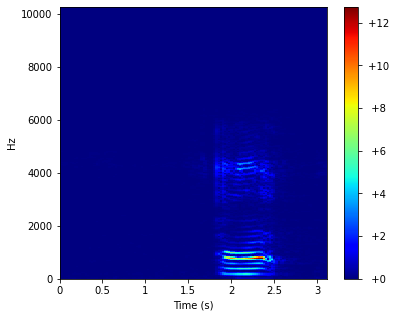

In [8]:
# 可以看一下資料
for x_S,y in val_ds_stft:
    print(x_S.shape,x_S.numpy().min(),x_S.numpy().max())
    print(y)
    break
plt.figure(figsize=(6,5))
ldp.specshow(x_S.numpy().T,sr=SR,x_axis="s",y_axis="hz",cmap="jet") # 記得做transpose
plt.colorbar(format="%+4.f")
plt.show()

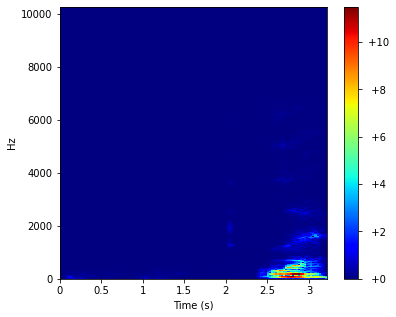

(257, 129)

In [9]:
# 跟librosa差不多，librosa有做time padding，會長一些
x_S_=librosa.stft(x.numpy(),n_fft=N,hop_length=H)
plt.figure(figsize=(6,5))
ldp.specshow(abs(x_S_),sr=SR,x_axis="s",y_axis="hz",cmap="jet")
plt.colorbar(format="%+4.f")
plt.show()
x_S_.shape

In [7]:
%%time
# 預讀資料，放進GPU
for x_S,y in tran_ds_stft:
    pass

CPU times: user 3min 39s, sys: 2.24 s, total: 3min 41s
Wall time: 2min 24s


## RNN Audio classifcation

我們可使用RNN來做對剛剛的頻譜作classification的訓練

In [10]:
# 抓一下 data的大小
for example_spectrograms, example_spect_labels in tran_ds_stft.take(1):
  break
input_shape = example_spectrograms.shape.as_list()

In [11]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [36]:
inputs = tf.keras.Input(shape=(None,input_shape[1]))
h = layers.LSTM(256, dropout=0.1)(inputs) # 用層LSTM
outputs = layers.Dense(len(class_dict),activation='softmax')(h)

model = models.Model(inputs=inputs, outputs=outputs)

In [37]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [38]:
EPOCHS = 20
history = model.fit(
    tran_ds_stft.batch(32),
    validation_data=val_ds_stft.batch(64),
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/20
200/200 [==============================] - 6s 24ms/step - loss: 1.5999 - accuracy: 0.3922 - val_loss: 1.4104 - val_accuracy: 0.4669
Epoch 2/20
200/200 [==============================] - 3s 13ms/step - loss: 1.2244 - accuracy: 0.5547 - val_loss: 1.0789 - val_accuracy: 0.6338
Epoch 3/20
200/200 [==============================] - 3s 13ms/step - loss: 0.9143 - accuracy: 0.6842 - val_loss: 0.9009 - val_accuracy: 0.6963
Epoch 4/20
200/200 [==============================] - 3s 13ms/step - loss: 0.7781 - accuracy: 0.7419 - val_loss: 0.8223 - val_accuracy: 0.7212
Epoch 5/20
200/200 [==============================] - 3s 16ms/step - loss: 0.6527 - accuracy: 0.7834 - val_loss: 0.5951 - val_accuracy: 0.7987
Epoch 6/20
200/200 [==============================] - 3s 14ms/step - loss: 0.5685 - accuracy: 0.8183 - val_loss: 0.5772 - val_accuracy: 0.8106
Epoch 7/20
200/200 [==============================] - 3s 13ms/step - loss: 0.5091 - accuracy: 0.8375 - val_loss: 0.5596 - val_accuracy: 0.8256

In [39]:
model_rnn.evaluate(val_ds_stft.batch(64))

25/25 [==============================] - 0s 14ms/step - loss: 0.5351 - accuracy: 0.8244


[0.5350607633590698, 0.8243749737739563]

In [ ]:
# model = models.Sequential([
#     layers.Input(shape=input_shape),
#     # Downsample the input.
#     layers.Resizing(32, 32),
#     # Normalize.
#     norm_layer,
#     layers.Conv2D(32, 3, activation='relu'),
#     layers.Conv2D(64, 3, activation='relu'),
#     layers.MaxPooling2D(),
#     layers.Dropout(0.25),
#     layers.Flatten(),
#     layers.Dense(128, activation='relu'),
#     layers.Dropout(0.5),
#     layers.Dense(num_labels),
# ])

## Reference
* TF官網教學: https://www.tensorflow.org/tutorials/audio/simple_audio
* https://towardsdatascience.com/audio-augmentations-in-tensorflow-48483260b169
* https://github.com/timsainb/tensorflow2-generative-models/blob/master/7.0-Tensorflow-spectrograms-and-inversion.ipynb